# Technical Indicators Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sb
sb.set()

import constants as c
import requests

## Pull Data from Polygon API

In [2]:
stock = 'AAPL'
date_from = '2021-06-01'
date_until = '2023-03-01'

def getIndicator(indicator, stock, date_from=None, date_until=None, timespan='day', adjusted=True, window=50, short_window=12, long_window=26, signal_window=9, series_type='close', expand_underlying=False, order='desc', limit=5000, apiKey=c.POLY_APIKEY):
    indicator = indicator.lower()
    stock = stock.upper()

    if indicator not in ['sma', 'ema', 'macd', 'rsi']:
        print('Indicator not found!')
        return None
    
    url = f'https://api.polygon.io/v1/indicators/{indicator}/{stock}'
    params = {
        'timestamp.gte': date_from,
        'timestamp.lte': date_until,
        'timespan': timespan,
        'adjusted': adjusted,
        'series_type': series_type,
        'expand_underlying': expand_underlying,
        'order': order,
        'limit': limit,
        'apiKey': apiKey,
    }

    if indicator == 'macd':
        params['short_window'] = short_window
        params['long_window'] = long_window
        params['signal_window'] = signal_window
    else:
        params['window'] = window

    try:
        response = requests.get(url=url, params=params).json()
        values = response['results']['values']
        return values
    except:
        print('Stock not found!')
        return None

def getStock(stock, date_from=None, date_until=None, multiplier=1, timespan='day', adjusted=True, sort='desc', limit=1000, apiKey=c.POLY_APIKEY):
    stock = stock.upper()
    url = f'https://api.polygon.io/v2/aggs/ticker/{stock}/range/{multiplier}/{timespan}/{date_from}/{date_until}'
    params = {
        'adjusted': adjusted,
        'sort': sort,
        'limit': limit,
        'apiKey': apiKey,
    }

    try:
        response = requests.get(url=url, params=params).json()
        return response
    except:
        print('Stock not found!')
        return None


### Get Indicator Data

In [3]:
sma_window = 20
sma_df = pd.DataFrame(getIndicator('sma', stock=stock, window=sma_window, date_from=date_from, date_until=date_until))
sma_df.rename({'value': 'sma_value'}, axis='columns', inplace=True)

ema_window = 50
ema_df = pd.DataFrame(getIndicator('ema', stock=stock, window=sma_window, date_from=date_from, date_until=date_until))
ema_df.rename({'value': 'ema_value'}, axis='columns', inplace=True)

macd_df = pd.DataFrame(getIndicator('macd', stock=stock, date_from=date_from, date_until=date_until))
macd_df.rename(columns={'value': 'macd_value', 'signal':'macd_signal', 'histogram': 'macd_histogram'}, inplace=True)

rsi_df = pd.DataFrame(getIndicator('rsi', stock=stock, date_from=date_from, date_until=date_until))
rsi_df.rename(columns={'value': 'rsi_value'}, inplace=True)

for item in [sma_df, ema_df, macd_df, rsi_df]:
    item['date'] = pd.to_datetime(item['timestamp'], unit='ms')
        
indicators_df = sma_df
for item in [ema_df, macd_df, rsi_df]:
    indicators_df = indicators_df.merge(item, 'inner', ['timestamp', 'date'])

indicators_df

,timestamp,sma_value,date,ema_value,macd_value,macd_signal,macd_histogram,rsi_value
0,1677646800000,150.6855,2023-03-01 05:00:00,148.202652,1.238105,2.510284,-1.272179,50.054565
1,1677560400000,150.6345,2023-02-28 05:00:00,148.507142,1.678721,2.828329,-1.149608,51.035765
2,1677474000000,150.4140,2023-02-27 05:00:00,148.622630,2.002871,3.115731,-1.112860,51.274985
3,1677214800000,150.3145,2023-02-24 05:00:00,148.696591,2.335544,3.393946,-1.058401,50.738108
4,1677128400000,150.1770,2023-02-23 05:00:00,148.905706,2.849385,3.658546,-0.809161,51.986073
...,...,...,...,...,...,...,...,...
436,1623038400000,125.5955,2021-06-07 04:00:00,126.182078,-0.918142,-0.947561,0.029419,52.728489
437,1622779200000,125.8110,2021-06-04 04:00:00,126.211771,-1.023264,-0.954916,-0.068348,52.722135
438,1622692800000,126.0035,2021-06-03 04:00:00,126.245641,-1.141537,-0.937829,-0.203708,51.211905
439,1622606400000,126.2315,2021-06-02 04:00:00,126.530446,-1.036619,-0.886902,-0.149717,52.270286


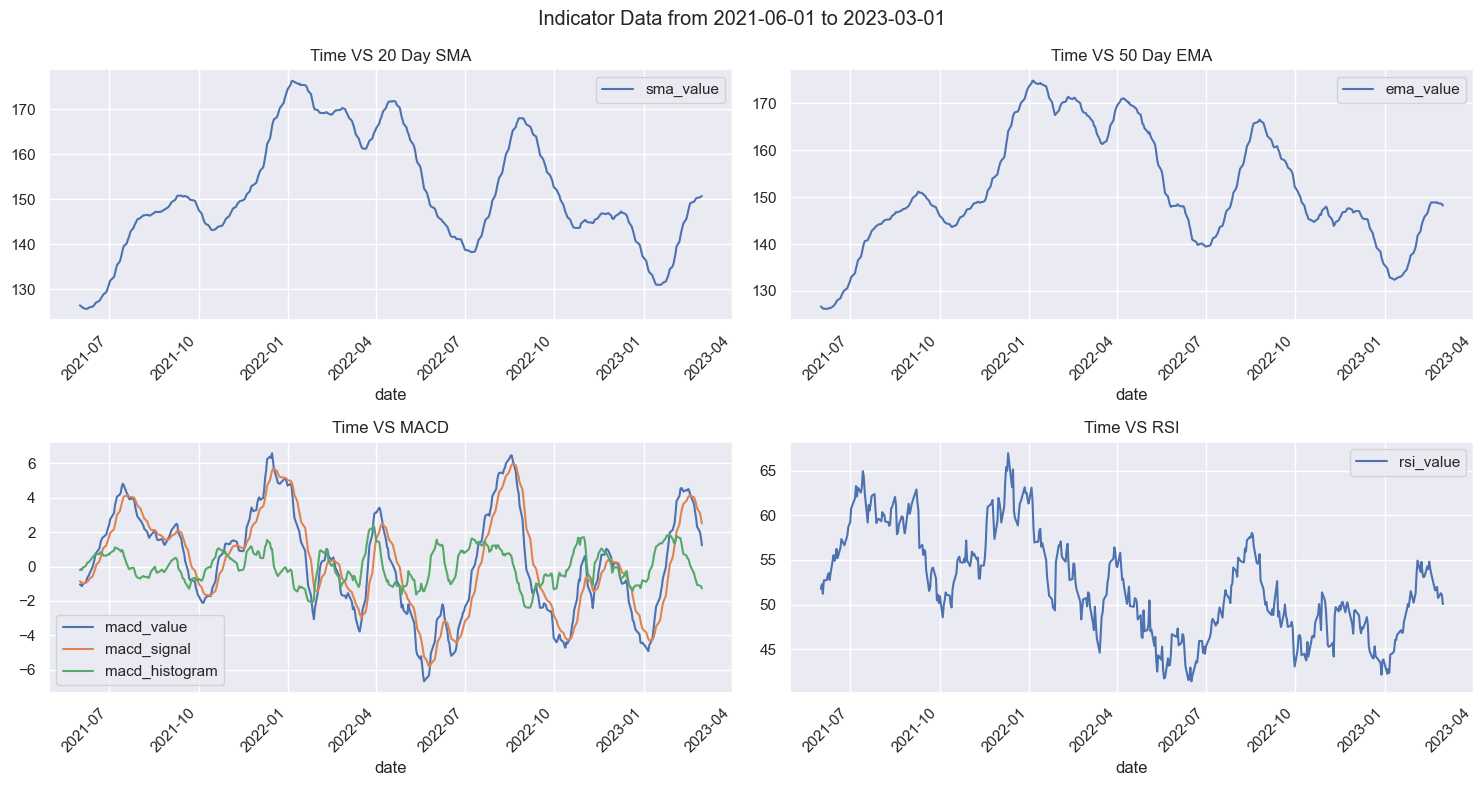

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
indicators_df.plot(x='date', y='sma_value', title=f"Time VS {sma_window} Day SMA", ax=ax[0][0], rot=45)
indicators_df.plot(x='date', y='ema_value', title=f"Time VS {ema_window} Day EMA", ax=ax[0][1], rot=45)
indicators_df.plot(x='date', y=['macd_value', 'macd_signal', 'macd_histogram'], title="Time VS MACD", ax=ax[1][0], rot=45)
indicators_df.plot(x='date', y='rsi_value', title="Time VS RSI", ax=ax[1][1], rot=45)
fig.suptitle(f'Indicator Data from {date_from} to {date_until}')
fig.tight_layout();

### Get Stock Data

In [5]:
stock_data = getStock(stock, date_from, date_until)['results']
stock_df = pd.DataFrame(stock_data)
stock_df['t'] = pd.to_datetime(stock_df['t'], unit='ms')
stock_df.rename(columns={
    'v': 'volume',
    'vw': 'volume-weighted price',
    'o': 'open price',
    'c': 'close price',
    'l': 'low price',
    'h': 'high price',
    'n': 'transactions',
    't': 'date',
}, inplace=True)
stock_df

,volume,volume-weighted price,open price,close price,high price,low price,date,transactions
0,55478991.0,145.8680,146.83,145.31,147.2285,145.0100,2023-03-01 05:00:00,461613
1,50546998.0,147.7996,147.05,147.41,149.0800,146.8300,2023-02-28 05:00:00,383779
2,44998470.0,148.1344,147.71,147.92,149.1700,147.4500,2023-02-27 05:00:00,418069
3,55469606.0,146.3861,147.11,146.71,147.1900,145.7202,2023-02-24 05:00:00,472221
4,48392049.0,148.8407,150.09,149.40,150.3400,147.2400,2023-02-23 05:00:00,425159
...,...,...,...,...,...,...,...,...
436,71057550.0,125.3691,126.17,125.90,126.3200,124.8321,2021-06-07 04:00:00,504254
437,75169343.0,125.3680,124.07,125.89,126.1600,123.8500,2021-06-04 04:00:00,467760
438,75699170.0,123.7708,124.68,123.54,124.8500,123.1300,2021-06-03 04:00:00,562249
439,58674262.0,124.7690,124.28,125.06,125.2400,124.0500,2021-06-02 04:00:00,461408


In [6]:
fig = go.Figure(
    data = [
        go.Candlestick(
            x = stock_df['date'],
            low = stock_df['low price'],
            high = stock_df['high price'],
            open = stock_df['open price'],
            close = stock_df['close price'],
            name = 'AAPL'
        ),
    ],
)
fig.add_trace(
    go.Scatter(
        x = indicators_df['date'],
        y = indicators_df['sma_value'],
        line = {
            'color': '#0062ff',
            'width': 1,
        },
        name = f'SMA {sma_window}',
    )
)
fig.add_trace(
    go.Scatter(
        x = indicators_df['date'],
        y = indicators_df['ema_value'],
        line = {
            'color': '#c27b00',
            'width': 1,
        },
        name = f'EMA {ema_window}',
    )
)
fig.show()

## EDA for SMA and EMA

In [7]:
sma_df

,timestamp,sma_value,date
0,1677646800000,150.6855,2023-03-01 05:00:00
1,1677560400000,150.6345,2023-02-28 05:00:00
2,1677474000000,150.4140,2023-02-27 05:00:00
3,1677214800000,150.3145,2023-02-24 05:00:00
4,1677128400000,150.1770,2023-02-23 05:00:00
...,...,...,...
436,1623038400000,125.5955,2021-06-07 04:00:00
437,1622779200000,125.8110,2021-06-04 04:00:00
438,1622692800000,126.0035,2021-06-03 04:00:00
439,1622606400000,126.2315,2021-06-02 04:00:00
